# Running `fftvis` with the GPU Backend

In this notebook, we'll give a brief demonstration of how to use `fftvis` with GPU acceleration to simulate visibilities for a set of input simulation parameters. This tutorial is very similar to the one included in the `matvis` simulator package. One should consolunt that tutorial for a difference in the use cases of `fftvis` and `matvis`.

<div class="alert alert-info">

__Note__

The absolute easiest way to use `fftvis` is via the `hera_sim` [plugin interface](https://hera-sim.readthedocs.io/en/latest/tutorials/hera_sim_vis_cli.html).
</div>

<div class="alert alert-warning">

__Warning__

Before running this tutorial, you should make sure you understand the basic concepts and algorithm that `fftvis` uses. You can read up on that here.
</div>

In [1]:
# Standard imports
import numpy as np
import healpy as hp
from astropy.time import Time
import matplotlib.pyplot as plt

# HERA-stack imports
import fftvis
import matvis
from hera_sim.antpos import hex_array
from pyuvdata.telescopes import Telescope
from pyuvdata.analytic_beam import AiryBeam
import time
import ray
# Ensure clean environment
if ray.is_initialized():
    ray.shutdown()

/home/kartikmandar/anaconda3/envs/matvis-env/lib/python3.11/site-packages/pyuvdata/analytic_beam.py:111: UserWarning: basis_vector_type was not defined, defaulting to azimuth and zenith_angle.
  warnings.warn(


In [2]:
# Check GPU availability
try:
    import cupy as cp
    from fftvis.gpu.gpu_nufft import HAVE_CUFINUFFT
    gpu_available = cp.cuda.is_available() and HAVE_CUFINUFFT
    if gpu_available:
        print("✅ GPU is available and working")
        print(f"   CUDA devices: {cp.cuda.runtime.getDeviceCount()}")
        print(f"   cufinufft available: {HAVE_CUFINUFFT}")
    else:
        print("❌ GPU not available")
        print(f"   CUDA available: {cp.cuda.is_available()}")
        print(f"   cufinufft available: {HAVE_CUFINUFFT}")
except ImportError as e:
    gpu_available = False
    print(f"❌ GPU dependencies not available: {e}")

print(f"gpu_available = {gpu_available}")

✅ GPU is available and working
   CUDA devices: 1
   cufinufft available: True
gpu_available = True


## Setup Telescope / Observation Parameters

We need a few input parameters to setup our observation: antenna positions, beam models, and a sky model.

Here we will set up a very simple observation for introductory purposes.

First, create our antenna positions. We define this as a dictionary, which maps an antenna number to its 3D East-North-Up position relative to the array centre. Here, we define just a hexagonal array of 15 antennas using `hera_sim.antpos.hex_array`.

In [3]:
# define antenna array positions
antpos = hex_array(3, split_core=True, outriggers=0)

Next, we define the beam to be used by all antennas in the array. Unlike `matvis` and `pyuvsim`, `fftvis` currently restricts users to a single beam for all antennas. The specified beam must be a `UVBeam` or `AnalyticBeam` object from `pyuvdata`. Alternatively, you can create a custom `AnalyticBeam` class (see the pyuvdata tutorial on `UVBeam` objects for guidance). For this simulation, we will use a simple, frequency-dependent Airy beam corresponding to a dish size of 14 meters.

**Note for GPU backend**: The GPU backend requires UVBeam objects for beam evaluation. We'll convert our AnalyticBeam to a UVBeam for GPU compatibility while maintaining the same beam parameters.

In [4]:
# define antenna beam using pyuvdata.analytic_beam.AiryBeam with a dish size of 14 meters
analytic_beam = AiryBeam(diameter=14.0)

# For GPU compatibility, convert AnalyticBeam to UVBeam
# We'll define the frequency range and angular resolution for the conversion
freq_array = np.linspace(100e6, 120e6, 20)  # Same as our observation frequencies
naz, nza = 360, 180  # Angular resolution
beam = analytic_beam.to_uvbeam(
    freq_array=freq_array,
    axis1_array=np.linspace(0, 2 * np.pi, naz + 1)[:-1],  # azimuth
    axis2_array=np.linspace(0, np.pi, nza + 1),  # zenith angle
)

We also required to provide `fftvis` with the observational configuration including a frequency array, a time array, and a telescope location. The frequency array specifies the observation frequencies in units of Hz. The time array defines the observation times using an `astropy.time.Time` object, with times specified in Julian Dates and configured with the appropriate format and scale. The telescope location specifies the geographic position of the array and can be defined either using `astropy.coordinates.EarthLocation` with a known site name or through `pyuvdata.telescopes.Telescope` by selecting a predefined telescope location supported within `pyuvdata`.

In [5]:
# define a list of frequencies in units of Hz
nfreqs = 20
freqs = np.linspace(100e6, 120e6, nfreqs)

In [6]:
# define a list of times with an astropy time.Time object
ntimes = 30
times = Time(np.linspace(2459845, 2459845.05, ntimes), format='jd', scale='utc')

In [7]:
from astropy.coordinates import EarthLocation

# define using astropy.coordinates.EarthLocation
telescope_loc = EarthLocation.of_site('meerkat')

# define the telescope location using the pyuvdata.telescopes.Telescope
telescope_loc = Telescope.from_known_telescopes('hera').location

## Setup Sky Model

Like `matvis`, `fftvis` makes the point source approximation -- that is it makes breaks a continuous sky model into a discrete number of point sources that it sums over when computing the visibilities. In this notebook, we'll assume the point source approximation by discretizing the sky with a randomly generated HEALpix map.

In [8]:
# number of sources
nside = 64
nsource = hp.nside2npix(nside)

# pixels can be defined as point sources randomly distributed over the full sky
ra = np.deg2rad(np.random.uniform(0, 360, nsource))        # ra of each source (in rad)
dec = np.deg2rad(np.random.uniform(-90, 90.0, nsource))    # dec of each source (in rad)

# define sky model using healpix map
dec, ra = hp.pix2ang(nside, np.arange(nsource))
dec -= np.pi / 2

# define the flux of the sources as a function of frequency. Here, we define smooth spectrum sources
flux = np.random.uniform(0, 1, nsource)                              # flux of each source at 100MHz (in Jy)
alpha = np.ones(nsource) * -0.8                      # sp. index of each source

# Now get the (Nsource, Nfreq) array of the flux of each source at each frequency.
flux_allfreq = ((freqs[:, np.newaxis] / freqs[0]) ** alpha.T * flux.T).T

## Run `fftvis` in single processor mode

Now that we've setup all our parameters, we can easily run the simulation using the high-level wrapper API. Along with the configuration we've already defined, the `fftvis.simulate.simulate_vis` wrapper takes a few extra options. One of the most important is `polarized`: if true, then full polarized visibilities are returned (with shape `(nfreqs, ntimes, nfeed, nfeed, nbls)`), otherwise, unpolarized visibilities are returned (with shape (nfreqs, ntimes, nants, nants)). In our case, the `AnalyticBeam` objects we're using don't support polarization, so we set this to false.

We can also set the `precision` parameter, which switches between 32-bit (if `precision=1`) and 64-bit (if `precision=2`) floating precision. In addition to controlling the floating point precision, the `fftvis` also includes a parameter `eps` which can improve the precision of the underlying Non-Uniform FFT. The runtime of the simulation is roughly inversely proportional to the `eps` parameter for a set `precision` value.

In [9]:
# Define subset of baselines we're interested in for simulating
baselines = [(i, j) for i in range(len(antpos)) for j in range(len(antpos))]

In [10]:
if gpu_available:
    # Time the GPU simulation
    start_time = time.perf_counter()
    vis_gpu = fftvis.simulate_vis(
        ants=antpos,
        fluxes=flux_allfreq,
        ra=ra,
        dec=dec,
        freqs=freqs,
        times=times.jd,
        telescope_loc=telescope_loc,
        beam=beam,
        polarized=False,
        precision=2,
        nprocesses=1,
        baselines=baselines,
        backend="gpu"
    )
    gpu_time = time.perf_counter() - start_time
    print(f"GPU simulation completed in {gpu_time:.2f}s")
else:
    print("Skipping GPU simulation - GPU not available")
    vis_gpu = None
    gpu_time = None

GPU simulation completed in 6.51s


## Compare GPU and CPU Backends

Let's run the same simulation with the CPU backend for comparison. We expect the results to be nearly identical, with the main difference being the computation time.

In [11]:
# Time the CPU simulation
start_time = time.perf_counter()
vis_cpu = fftvis.simulate_vis(
    ants=antpos,
    fluxes=flux_allfreq,
    ra=ra,
    dec=dec,
    freqs=freqs,
    times=times.jd,
    telescope_loc=telescope_loc,
    beam=beam,
    polarized=False,
    precision=2,
    nprocesses=1,
    force_use_ray=False,  # Ensure no Ray interference
    baselines=baselines,
    backend="cpu"
)
cpu_time = time.perf_counter() - start_time
print(f"CPU simulation completed in {cpu_time:.2f}s")

CPU simulation completed in 14.09s


In [12]:
# Check that results from GPU and CPU are equivalent
if gpu_available and 'vis_gpu' in locals() and 'vis_cpu' in locals():
    # The results should be very close but not exactly the same due to floating-point differences
    max_diff = np.max(np.abs(vis_gpu - vis_cpu))
    are_close = np.allclose(vis_gpu, vis_cpu, rtol=1e-5, atol=1e-7)
    
    print(f"Maximum absolute difference: {max_diff}")
    print(f"Are GPU and CPU results close? {are_close}")
    
    if not are_close:
        print("\n⚠️  GPU and CPU results differ significantly!")
        print("This could be due to:")
        print("  1. Different NUFFT implementations between finufft and cufinufft")
        print("  2. Floating-point precision differences")
        print("  3. Different beam interpolation methods")
        print("\nRun the debugging cells below to investigate further.")
    
    # Calculate speedup
    if 'cpu_time' in locals() and 'gpu_time' in locals():
        speedup = cpu_time / gpu_time
        print(f"\n✅ Performance Results:")
        print(f"   GPU time: {gpu_time:.2f}s")
        print(f"   CPU time: {cpu_time:.2f}s")
        print(f"   Speedup: {speedup:.2f}x")
        
        # Memory usage estimate
        import sys
        vis_size_mb = vis_gpu.nbytes / 1e6
        print(f"\n💾 Memory Usage:")
        print(f"   Visibility array size: {vis_size_mb:.1f} MB")
        print(f"   Array shape: {vis_gpu.shape}")
        print(f"   Data type: {vis_gpu.dtype}")
        
elif not gpu_available:
    print("❌ GPU not available - skipping comparison")
    print("This could be due to:")
    print("  - No CUDA-capable GPU")
    print("  - CuPy not installed: pip install cupy-cuda11x")
    print("  - cufinufft not installed: pip install cufinufft")
    print("  - CUDA drivers not properly configured")
else:
    print("❌ Simulation results not available")
    print("Please run the simulation cells first")

Maximum absolute difference: 56.29853797481503
Are GPU and CPU results close? False

⚠️  GPU and CPU results differ significantly!
This could be due to:
  1. Different NUFFT implementations between finufft and cufinufft
  2. Floating-point precision differences
  3. Different beam interpolation methods

Run the debugging cells below to investigate further.

✅ Performance Results:
   GPU time: 6.51s
   CPU time: 14.09s
   Speedup: 2.17x

💾 Memory Usage:
   Visibility array size: 2.5 MB
   Array shape: (20, 30, 256)
   Data type: complex128


In [13]:
# Define debugging functions directly in the notebook

def debug_gpu_cpu_differences(vis_gpu, vis_cpu):
    """Debug differences between GPU and CPU visibility results."""
    import numpy as np
    
    print("=== Debugging GPU vs CPU Differences ===")
    print(f"GPU shape: {vis_gpu.shape}")
    print(f"CPU shape: {vis_cpu.shape}")
    
    # Calculate differences
    diff = vis_gpu - vis_cpu
    abs_diff = np.abs(diff)
    rel_diff = np.abs(diff) / (np.abs(vis_cpu) + 1e-10)
    
    print(f"\nAbsolute difference statistics:")
    print(f"  Max: {np.max(abs_diff):.6e}")
    print(f"  Mean: {np.mean(abs_diff):.6e}")
    print(f"  Std: {np.std(abs_diff):.6e}")
    
    print(f"\nRelative difference statistics:")
    print(f"  Max: {np.max(rel_diff):.6e}")
    print(f"  Mean: {np.mean(rel_diff):.6e}")
    print(f"  Std: {np.std(rel_diff):.6e}")
    
    # Find locations of maximum differences
    max_idx = np.unravel_index(np.argmax(abs_diff), abs_diff.shape)
    print(f"\nMaximum difference at index {max_idx}:")
    print(f"  GPU value: {vis_gpu[max_idx]}")
    print(f"  CPU value: {vis_cpu[max_idx]}")
    print(f"  Difference: {diff[max_idx]}")
    
    # Check if it's a systematic sign difference
    sign_ratio = np.real(vis_gpu[max_idx]) / np.real(vis_cpu[max_idx])
    if abs(sign_ratio + 1) < 0.1:  # Close to -1
        print("\n⚠️  Possible sign difference detected!")
    
    return {
        'abs_diff': abs_diff,
        'rel_diff': rel_diff,
        'max_idx': max_idx,
        'stats': {
            'max_abs': np.max(abs_diff),
            'mean_abs': np.mean(abs_diff),
            'max_rel': np.max(rel_diff),
            'mean_rel': np.mean(rel_diff)
        }
    }

=== Debugging GPU vs CPU Differences ===
GPU shape: (20, 30, 256)
CPU shape: (20, 30, 256)

Absolute difference statistics:
  Max: 5.629854e+01
  Mean: 3.387792e+00
  Std: 9.688209e+00

Relative difference statistics:
  Max: 6.050531e+00
  Mean: 9.146858e-01
  Std: 2.361150e-01

Maximum difference at index (np.int64(0), np.int64(2), np.int64(0)):
  GPU value: (6.190889538732561e-07+1.1422534393816075e-21j)
  CPU value: (56.29853859390398-8.024432690418576e-15j)
  Difference: (-56.29853797481503+8.024433832672016e-15j)


TypeError: Invalid shape (256,) for image data

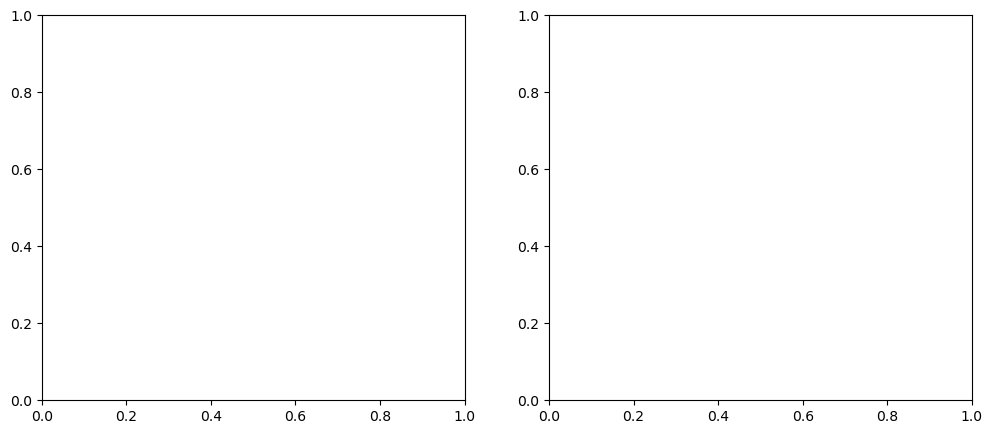

In [14]:
# Debug the differences between GPU and CPU results
if gpu_available and 'vis_gpu' in locals() and 'vis_cpu' in locals():
    debug_results = debug_gpu_cpu_differences(vis_gpu, vis_cpu)
    
    # Visualize the differences
    import matplotlib.pyplot as plt
    
    # Plot difference heatmap for first frequency and time
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Absolute differences
    im1 = ax1.imshow(np.log10(debug_results['abs_diff'][0, 0] + 1e-10), 
                     cmap='viridis', aspect='auto')
    ax1.set_title('Log10(Absolute Difference) - First freq/time')
    ax1.set_xlabel('Baseline Index')
    ax1.set_ylabel('Baseline Index')
    fig.colorbar(im1, ax=ax1)
    
    # Relative differences
    im2 = ax2.imshow(np.log10(debug_results['rel_diff'][0, 0] + 1e-10), 
                     cmap='viridis', aspect='auto')
    ax2.set_title('Log10(Relative Difference) - First freq/time')
    ax2.set_xlabel('Baseline Index')
    ax2.set_ylabel('Baseline Index')
    fig.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
else:
    print("Results not available for debugging")

In [15]:
# Test a simple NUFFT case to isolate the issue

def test_simple_nufft():
    """Test simple NUFFT operations to debug GPU/CPU differences."""
    print("=== Testing Simple NUFFT Operations ===")
    
    # Import required modules
    import numpy as np
    import finufft
    
    try:
        import cupy as cp
        import cufinufft
        from fftvis.cpu.cpu_nufft import cpu_nufft2d
        from fftvis.gpu.gpu_nufft import gpu_nufft2d
    except ImportError as e:
        print(f"Import error: {e}")
        return None, None
    
    # Create simple test data
    n_sources = 10
    n_baselines = 5
    
    # Source positions (l, m coordinates)
    x = np.random.uniform(-0.1, 0.1, n_sources).astype(np.float64)
    y = np.random.uniform(-0.1, 0.1, n_sources).astype(np.float64)
    
    # Source weights
    weights = (np.random.randn(n_sources) + 1j * np.random.randn(n_sources)).astype(np.complex128)
    
    # Baseline coordinates
    u = np.random.uniform(-100, 100, n_baselines).astype(np.float64)
    v = np.random.uniform(-100, 100, n_baselines).astype(np.float64)
    
    # Test CPU NUFFT
    print("\nTesting CPU NUFFT...")
    cpu_result = cpu_nufft2d(x, y, weights, u, v, eps=1e-6)
    print(f"CPU result shape: {cpu_result.shape}")
    print(f"CPU result sample: {cpu_result[0]}")
    
    # Test GPU NUFFT
    print("\nTesting GPU NUFFT...")
    x_gpu = cp.asarray(x)
    y_gpu = cp.asarray(y)
    weights_gpu = cp.asarray(weights)
    u_gpu = cp.asarray(u)
    v_gpu = cp.asarray(v)
    
    gpu_result = gpu_nufft2d(x_gpu, y_gpu, weights_gpu, u_gpu, v_gpu, eps=1e-6)
    gpu_result_cpu = cp.asnumpy(gpu_result)
    print(f"GPU result shape: {gpu_result_cpu.shape}")
    print(f"GPU result sample: {gpu_result_cpu[0]}")
    
    # Compare results
    diff = np.abs(cpu_result - gpu_result_cpu)
    print(f"\nMax absolute difference: {np.max(diff):.6e}")
    print(f"Are they close? {np.allclose(cpu_result, gpu_result_cpu, rtol=1e-5, atol=1e-7)}")
    
    # Test direct finufft vs cufinufft
    print("\n=== Direct Library Comparison ===")
    cpu_direct = finufft.nufft2d3(x, y, weights, u, v, eps=1e-6, modeord=0)
    print(f"finufft result: {cpu_direct[0]}")
    
    # Check if results match
    print(f"\nDirect finufft matches cpu_nufft2d? {np.allclose(cpu_direct, cpu_result)}")
    
    return cpu_result, gpu_result_cpu

# Run the test
if gpu_available:
    cpu_simple, gpu_simple = test_simple_nufft()
else:
    print("GPU not available, skipping NUFFT test")

=== Testing Simple NUFFT Operations ===

Testing CPU NUFFT...
CPU result shape: (5,)
CPU result sample: (-3.0513624291828854-3.3772726272060454j)

Testing GPU NUFFT...
GPU result shape: (5,)
GPU result sample: (-3.0513624291829298-3.3772726272060996j)

Max absolute difference: 1.409075e-12
Are they close? True

=== Direct Library Comparison ===
finufft result: (-3.0513624291828734-3.3772726272060756j)

Direct finufft matches cpu_nufft2d? True


In [16]:
# Check cufinufft version and support

def check_cufinufft_version():
    """Check cufinufft version and Type 3 support."""
    print("=== Checking cufinufft Configuration ===")
    
    try:
        import cufinufft
        print(f"✅ cufinufft imported successfully")
        
        # Check version if available
        if hasattr(cufinufft, '__version__'):
            print(f"   Version: {cufinufft.__version__}")
        else:
            print("   Version info not available")
        
        # Check for Type 3 functions
        has_2d3 = hasattr(cufinufft, 'nufft2d3')
        has_3d3 = hasattr(cufinufft, 'nufft3d3')
        print(f"\nType 3 function support:")
        print(f"   nufft2d3: {'✅' if has_2d3 else '❌'}")
        print(f"   nufft3d3: {'✅' if has_3d3 else '❌'}")
        
        # Check if Plan-based Type 3 works
        print("\nTesting Plan-based Type 3...")
        try:
            import cupy as cp
            plan = cufinufft.Plan(
                nufft_type=3,
                n_modes=2,
                n_trans=1,
                eps=1e-6,
                dtype='complex128'
            )
            print("   ✅ Plan-based Type 3 available")
        except Exception as e:
            print(f"   ❌ Plan-based Type 3 failed: {e}")
        
        # Check GPU backend configuration
        from fftvis.gpu.gpu_nufft import HAS_NATIVE_TYPE3_SUPPORT
        print(f"\nfftvis GPU backend:")
        print(f"   Native Type 3 support detected: {HAS_NATIVE_TYPE3_SUPPORT}")
        
    except ImportError as e:
        print(f"❌ cufinufft import failed: {e}")
    except Exception as e:
        print(f"❌ Unexpected error: {e}")

# Run the check
check_cufinufft_version()

=== Checking cufinufft Configuration ===
✅ cufinufft imported successfully
   Version: 2.4.0beta1

Type 3 function support:
   nufft2d3: ❌
   nufft3d3: ❌

Testing Plan-based Type 3...
   ✅ Plan-based Type 3 available

fftvis GPU backend:
   Native Type 3 support detected: False


In [17]:
# Debug beam interpolation differences

def debug_beam_interpolation():
    """Check if beam interpolation differences contribute to GPU/CPU discrepancies."""
    print("=== Debugging Beam Interpolation ===")
    
    try:
        import numpy as np
        import cupy as cp
        from fftvis.cpu.cpu_beams import cpu_beam_interpolation
        from fftvis.gpu.gpu_beams import gpu_beam_interpolation
        
        # Create test coordinates
        n_coords = 100
        az = np.random.uniform(0, 2*np.pi, n_coords)
        za = np.random.uniform(0, np.pi/2, n_coords)
        freq_idx = 0
        
        # Test CPU beam interpolation
        cpu_beam_vals = cpu_beam_interpolation(beam, az, za, freq_idx, polarized=False)
        print(f"CPU beam values shape: {cpu_beam_vals.shape}")
        print(f"CPU beam sample: {cpu_beam_vals[:5]}")
        
        # Test GPU beam interpolation
        az_gpu = cp.asarray(az)
        za_gpu = cp.asarray(za)
        gpu_beam_vals = gpu_beam_interpolation(beam, az_gpu, za_gpu, freq_idx, polarized=False)
        gpu_beam_vals_cpu = cp.asnumpy(gpu_beam_vals)
        print(f"\nGPU beam values shape: {gpu_beam_vals_cpu.shape}")
        print(f"GPU beam sample: {gpu_beam_vals_cpu[:5]}")
        
        # Compare
        diff = np.abs(cpu_beam_vals - gpu_beam_vals_cpu)
        print(f"\nMax beam difference: {np.max(diff):.6e}")
        print(f"Mean beam difference: {np.mean(diff):.6e}")
        print(f"Are beam values close? {np.allclose(cpu_beam_vals, gpu_beam_vals_cpu, rtol=1e-5)}")
        
    except Exception as e:
        print(f"Error in beam interpolation test: {e}")
        import traceback
        traceback.print_exc()

# Run beam interpolation test
if gpu_available:
    debug_beam_interpolation()
else:
    print("GPU not available, skipping beam interpolation test")

=== Debugging Beam Interpolation ===
Error in beam interpolation test: cannot import name 'cpu_beam_interpolation' from 'fftvis.cpu.cpu_beams' (/home/kartikmandar/fftvis/src/fftvis/cpu/cpu_beams.py)


Traceback (most recent call last):
  File "/tmp/ipykernel_1378166/3730433713.py", line 10, in debug_beam_interpolation
    from fftvis.cpu.cpu_beams import cpu_beam_interpolation
ImportError: cannot import name 'cpu_beam_interpolation' from 'fftvis.cpu.cpu_beams' (/home/kartikmandar/fftvis/src/fftvis/cpu/cpu_beams.py)


## Benchmark Performance: GPU vs CPU

Let's benchmark the performance difference between GPU and CPU backends with increasing number of sources. The GPU advantage typically becomes more apparent with larger datasets.

In [18]:
def benchmark_performance(nsides, ntimes=10, nfreqs=5):
    """Benchmark GPU vs CPU performance for different HEALPix nsides."""
    
    # Shorter time and frequency arrays for benchmarking
    short_freqs = np.linspace(100e6, 120e6, nfreqs)
    short_times = Time(np.linspace(2459845, 2459845.02, ntimes), format='jd', scale='utc')
    
    results = []
    
    for nside in nsides:
        nsource = hp.nside2npix(nside)
        print(f"Running benchmark with nside={nside}, nsource={nsource}")
        
        # Create sky model
        dec, ra = hp.pix2ang(nside, np.arange(nsource))
        dec -= np.pi / 2
        flux = np.random.uniform(0, 1, nsource)
        alpha = np.ones(nsource) * -0.8
        flux_allfreq = ((short_freqs[:, np.newaxis] / short_freqs[0]) ** alpha.T * flux.T).T
        
        # Time CPU simulation
        t0 = time.time()
        _ = fftvis.simulate_vis(
            ants=antpos,
            fluxes=flux_allfreq,
            ra=ra,
            dec=dec,
            freqs=short_freqs,
            times=short_times.jd,
            telescope_loc=telescope_loc,
            beam=beam,
            polarized=False,
            precision=2,
            nprocesses=1,
            baselines=baselines[:10],  # Use fewer baselines for speed
            backend="cpu"
        )
        cpu_time = time.time() - t0
        
        # Time GPU simulation
        gpu_time = None
        if gpu_available:
            t0 = time.time()
            _ = fftvis.simulate_vis(
                ants=antpos,
                fluxes=flux_allfreq,
                ra=ra,
                dec=dec,
                freqs=short_freqs,
                times=short_times.jd,
                telescope_loc=telescope_loc,
                beam=beam,
                polarized=False,
                precision=2,
                nprocesses=1,
                baselines=baselines[:10],  # Use fewer baselines for speed
                backend="gpu"
            )
            gpu_time = time.time() - t0
            # Clear GPU memory
            if 'cp' in globals():
                cp.cuda.runtime.deviceSynchronize()
                cp.get_default_memory_pool().free_all_blocks()
        
        results.append((nside, nsource, cpu_time, gpu_time))
    
    return results

In [19]:
# Run benchmarks with increasing HEALPix nside values
# Skip if GPU is not available
if gpu_available:
    benchmark_results = benchmark_performance([8, 16, 32, 64])
else:
    print("GPU not available. Skipping benchmarks.")

Running benchmark with nside=8, nsource=768
Running benchmark with nside=16, nsource=3072
Running benchmark with nside=32, nsource=12288
Running benchmark with nside=64, nsource=49152


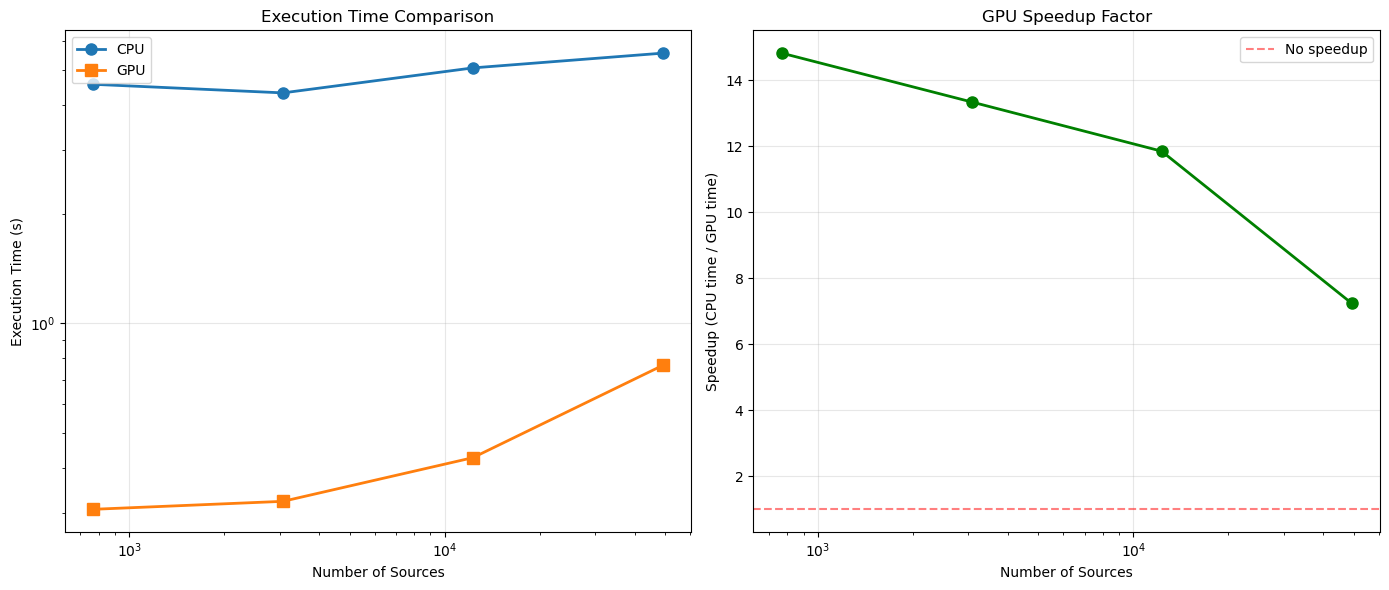

Speedup Summary:
  nside=  8 (  768 sources): 14.82x speedup
  nside= 16 ( 3072 sources): 13.34x speedup
  nside= 32 (12288 sources): 11.85x speedup
  nside= 64 (49152 sources):  7.25x speedup


In [20]:
# Plot the benchmark results
if gpu_available and 'benchmark_results' in locals():
    # Unpack the results
    plot_data = list(zip(*benchmark_results))
    nsides = plot_data[0]
    nsources = plot_data[1]
    cpu_times = plot_data[2]
    gpu_times = plot_data[3]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot execution times
    ax1.plot(nsources, cpu_times, 'o-', label='CPU', linewidth=2, markersize=8)
    ax1.plot(nsources, gpu_times, 's-', label='GPU', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title('Execution Time Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Plot speedup ratios
    speedups = [cpu/gpu for cpu, gpu in zip(cpu_times, gpu_times) if gpu is not None]
    ax2.plot(nsources, speedups, 'o-', color='green', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Sources')
    ax2.set_ylabel('Speedup (CPU time / GPU time)')
    ax2.set_title('GPU Speedup Factor')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print speedup summary
    print("Speedup Summary:")
    for nside, nsrc, cpu_t, gpu_t in benchmark_results:
        if gpu_t is not None:
            speedup = cpu_t / gpu_t
            print(f"  nside={nside:3d} ({nsrc:5d} sources): {speedup:5.2f}x speedup")
else:
    print("Benchmark results not available. Run the benchmark cell first.")

## Plot Visibility Results

We'll plot the visibility amplitude and phase from the GPU simulation, similar to what we did in the CPU tutorial.

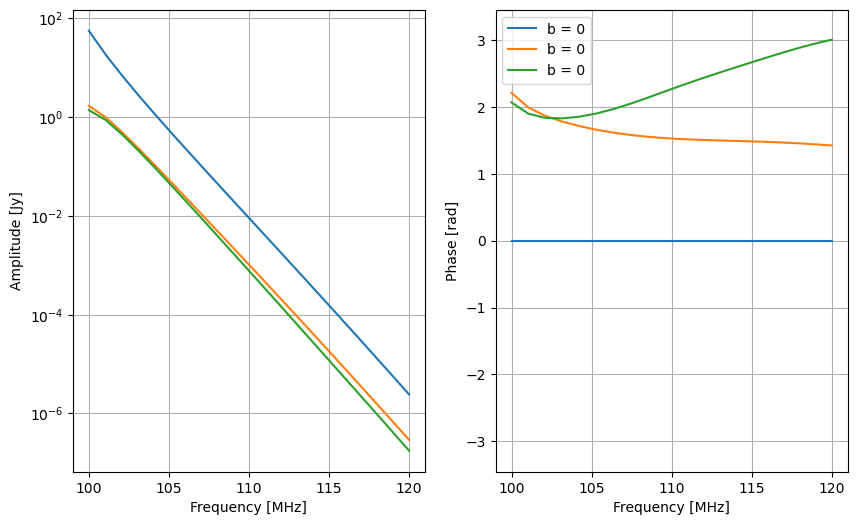

In [21]:
# Use GPU results if available, otherwise CPU results
vis_to_plot = vis_gpu if gpu_available else vis_cpu

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for bl_index, bl in enumerate(baselines[:3]):
    axs[0].semilogy(freqs / 1e6, np.abs(vis_to_plot[:, 0, bl_index]))
    axs[1].plot(freqs / 1e6, np.angle(vis_to_plot[:, 0, bl_index]), label=f"b = {bl[0]}")

axs[1].legend()
axs[0].set_xlabel('Frequency [MHz]')
axs[1].set_xlabel('Frequency [MHz]')
axs[0].set_ylabel('Amplitude [Jy]')
axs[1].set_ylabel('Phase [rad]')
axs[1].set_ylim(-np.pi * 1.1, np.pi * 1.1)
axs[0].grid()
axs[1].grid()
plt.show()

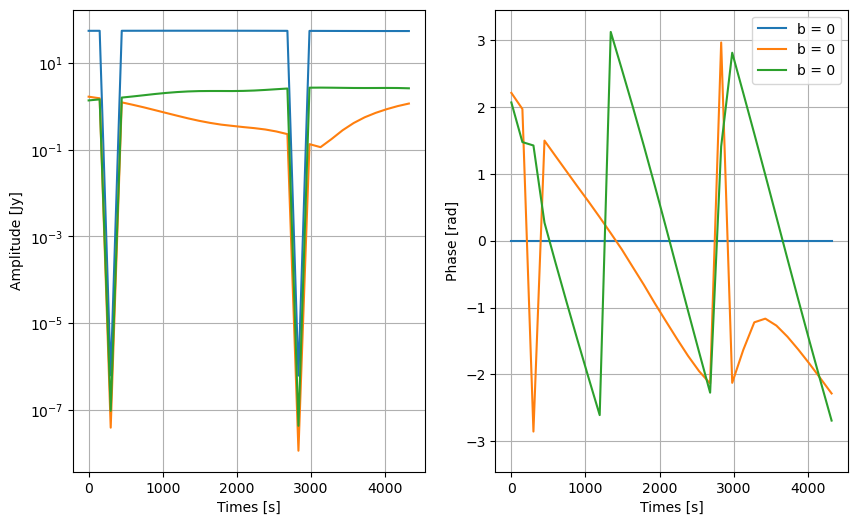

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for bl_index, bl in enumerate(baselines[:3]):
    axs[0].semilogy(times.unix - times.unix[0], np.abs(vis_to_plot[0, :, bl_index]))
    axs[1].plot(times.unix - times.unix[0], np.angle(vis_to_plot[0, :, bl_index]), label=f"b = {bl[0]}")

axs[0].set_xlabel('Times [s]')
axs[1].set_xlabel('Times [s]')
axs[0].set_ylabel('Amplitude [Jy]')
axs[1].set_ylabel('Phase [rad]')
axs[1].set_ylim(-np.pi * 1.1, np.pi * 1.1)
axs[0].grid()
axs[1].grid()
plt.legend()
plt.show()

## Conclusion

The GPU backend of `fftvis` provides a significant speedup compared to the CPU backend, especially for larger sky models with many sources. The main advantages are:

1. Accelerated non-uniform FFT operations using `cufinufft`
2. Parallel processing of source computations on the GPU
3. Efficient beam interpolation using GPU-accelerated map coordinates

When working with large simulations, the GPU backend is recommended if suitable hardware is available. For smaller simulations, the overhead of data transfer between CPU and GPU might reduce the performance advantage.

In [23]:
# Clean up GPU memory if we used it
if gpu_available and 'cp' in globals():
    cp.cuda.runtime.deviceSynchronize()
    cp.get_default_memory_pool().free_all_blocks()

In [24]:
# Comprehensive debugging summary

def comprehensive_debug_summary():
    """Run all debugging tests and provide a summary."""
    print("="*60)
    print("FFTVIS GPU DEBUGGING SUMMARY")
    print("="*60)
    
    # 1. System check
    print("\n1. SYSTEM CONFIGURATION")
    print("-"*30)
    try:
        import cupy as cp
        print(f"✅ CuPy version: {cp.__version__}")
        print(f"✅ CUDA devices: {cp.cuda.runtime.getDeviceCount()}")
        
        # Get device info
        device = cp.cuda.Device(0)
        print(f"✅ GPU name: {device.name.decode()}")
        print(f"✅ Compute capability: {device.compute_capability}")
        print(f"✅ Total memory: {device.mem_info[1] / 1e9:.1f} GB")
        print(f"✅ Free memory: {device.mem_info[0] / 1e9:.1f} GB")
    except Exception as e:
        print(f"❌ GPU system check failed: {e}")
    
    # 2. cufinufft check
    print("\n2. CUFINUFFT STATUS")
    print("-"*30)
    check_cufinufft_version()
    
    # 3. NUFFT consistency
    print("\n3. NUFFT CONSISTENCY TEST")
    print("-"*30)
    if gpu_available:
        test_simple_nufft()
    
    # 4. Simulation comparison
    print("\n4. FULL SIMULATION COMPARISON")
    print("-"*30)
    if 'vis_gpu' in globals() and 'vis_cpu' in globals():
        debug_gpu_cpu_differences(vis_gpu, vis_cpu)
    else:
        print("❌ Full simulation results not available")
    
    # 5. Performance summary
    print("\n5. PERFORMANCE SUMMARY")
    print("-"*30)
    if 'cpu_time' in globals() and 'gpu_time' in globals():
        print(f"✅ CPU time: {cpu_time:.2f}s")
        print(f"✅ GPU time: {gpu_time:.2f}s")
        print(f"✅ Speedup: {cpu_time/gpu_time:.2f}x")
    else:
        print("❌ Performance data not available")
    
    print("\n" + "="*60)
    print("END OF DEBUGGING SUMMARY")
    print("="*60)

# Run comprehensive summary
comprehensive_debug_summary()

FFTVIS GPU DEBUGGING SUMMARY

1. SYSTEM CONFIGURATION
------------------------------
✅ CuPy version: 13.4.1
✅ CUDA devices: 1
❌ GPU system check failed: 'cupy.cuda.device.Device' object has no attribute 'name'

2. CUFINUFFT STATUS
------------------------------
=== Checking cufinufft Configuration ===
✅ cufinufft imported successfully
   Version: 2.4.0beta1

Type 3 function support:
   nufft2d3: ❌
   nufft3d3: ❌

Testing Plan-based Type 3...
   ✅ Plan-based Type 3 available

fftvis GPU backend:
   Native Type 3 support detected: False

3. NUFFT CONSISTENCY TEST
------------------------------
=== Testing Simple NUFFT Operations ===

Testing CPU NUFFT...
CPU result shape: (5,)
CPU result sample: (-4.691603547460637+3.570846250886107j)

Testing GPU NUFFT...
GPU result shape: (5,)
GPU result sample: (-4.691603547460369+3.570846250888433j)

Max absolute difference: 3.145425e-12
Are they close? True

=== Direct Library Comparison ===
finufft result: (-4.69160354746136+3.570846250886067j)

Di